# `setup_anndata` Profiling

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

     |████████████████████████████████| 231 kB 7.0 MB/s 
     |████████████████████████████████| 678 kB 34.3 MB/s 
     |████████████████████████████████| 212 kB 53.5 MB/s 
     |████████████████████████████████| 242 kB 55.1 MB/s 
     |████████████████████████████████| 127 kB 45.4 MB/s 
     |████████████████████████████████| 813 kB 30.9 MB/s 
     |████████████████████████████████| 1.4 MB 26.0 MB/s 
     |████████████████████████████████| 3.2 MB 20.9 MB/s 
     |████████████████████████████████| 2.0 MB 29.5 MB/s 
     |████████████████████████████████| 8.8 MB 21.7 MB/s 
     |████████████████████████████████| 41 kB 108 kB/s 
     |████████████████████████████████| 48 kB 4.7 MB/s 
     |████████████████████████████████| 282 kB 43.1 MB/s 
     |████████████████████████████████| 125 kB 48.1 MB/s 
     |████████████████████████████████| 636 kB 34.3 MB/s 
     |████████████████████████████████| 829 kB 43.3 MB/s 
     |████████████████████████████████| 1.3 MB 41.5 MB/s 
     |█████████████

In [2]:
!pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-py3-none-any.whl size=30190 sha256=fe7322a0bf56ea99aca4b8f09ab51a67f9f4dab51425d9793606e68bdd1afbf3
  Stored in directory: /root/.cache/pip/wheels/56/19/d5/8cad06661aec65a04a0d6785b1a5ad035cb645b1772a4a0882
Successfully built memory-profiler


In [3]:
!pip install mplscience

## Imports

In [4]:
import contextlib
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
import mplscience
import scvi

%matplotlib inline

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## Load Data

In [5]:
full_adata = scvi.data.spleen_lymph_cite_seq(run_setup_anndata=False)

INFO     Downloading file at data/sln_111.h5ad                                               
Downloading...: 100%|██████████| 66657/66657.0 [00:00<00:00, 90105.51it/s]
INFO     Downloading file at data/sln_208.h5ad                                               
Downloading...: 100%|██████████| 70490/70490.0 [00:00<00:00, 78964.05it/s]


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [6]:
full_adata

AnnData object with n_obs × n_vars = 30474 × 13553
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
    obsm: 'isotypes_htos', 'protein_expression'

## totalVI

In [8]:
subset_sizes = [1e3, 2e3, 4e3, 8e3, 16e3, full_adata.n_obs]
mem_usages = []
mem_increments = []
runtimes = []

with open(os.devnull, mode="w") as devnull:
  for subset_size in subset_sizes:
    idxs = np.arange(full_adata.n_obs)
    np.random.shuffle(idxs)
    subset_idxs = idxs[:int(subset_size)]
    
    mem_subset_adata = full_adata[subset_idxs].copy()
    with contextlib.redirect_stdout(devnull):
      starting_mem_adata = sys.getsizeof(mem_subset_adata)
      mem_usages.append(memory_usage((scvi.model.TOTALVI.setup_anndata, (mem_subset_adata, "protein_expression"), dict(batch_key="batch")), max_usage=True))
      mem_increment_in_bytes = sys.getsizeof(mem_subset_adata) - starting_mem_adata
      mem_increments.append(mem_increment_in_bytes / 1024 / 1024)
    
    runtime_subset_adata = full_adata[subset_idxs].copy()
    with contextlib.redirect_stdout(devnull):
      start = time.time()
      scvi.model.TOTALVI.setup_anndata(runtime_subset_adata, "protein_expression", batch_key="batch")
      runtimes.append(time.time() - start)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [9]:
tmem = mem_increments[:]
trun = runtimes[:]

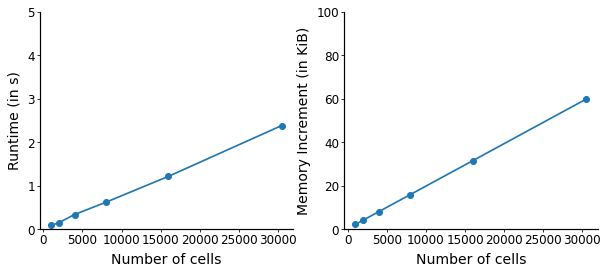

In [10]:
with mplscience.style_context():
  fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10, 4))

  # ax1.plot(subset_sizes, np.array(mem_usages) / 1024, marker="o")
  # ax1.set_title("setup_anndata Memory Usage Profiling")
  # ax1.set_xlabel("Number of cells")
  # ax1.set_ylabel("Memory Usage (in GiB)")
  # ax1.set_ylim((0, 10))

  ax2.plot(subset_sizes, trun, marker="o")
  # ax2.set_title("totalVI setup_anndata Runtime Profiling")
  ax2.set_xlabel("Number of cells")
  ax2.set_ylabel("Runtime (in s)")
  ax2.set_ylim((0, 5))

  ax3.plot(subset_sizes, np.array(tmem) * 1024, marker="o")
  # ax3.set_title("totalVI setup_anndata Memory Profiling")
  ax3.set_xlabel("Number of cells")
  ax3.set_ylabel("Memory Increment (in KiB)")
  ax3.set_ylim((0, 100))

  fig.savefig("totalVI_setup_anndata_profiling.pdf", bbox_inches="tight", dpi=300)

## scVI

In [12]:
subset_sizes = [1e3, 2e3, 4e3, 8e3, 16e3, full_adata.n_obs]
mem_usages = []
mem_increments = []
runtimes = []

with open(os.devnull, mode="w") as devnull:
  for subset_size in subset_sizes:
    idxs = np.arange(full_adata.n_obs)
    np.random.shuffle(idxs)
    subset_idxs = idxs[:int(subset_size)]
    
    mem_subset_adata = full_adata[subset_idxs].copy()
    with contextlib.redirect_stdout(devnull):
      starting_mem_adata = sys.getsizeof(mem_subset_adata)
      mem_usages.append(memory_usage((scvi.model.SCVI.setup_anndata, (mem_subset_adata,), dict(batch_key="batch")), max_usage=True))
      mem_increment_in_bytes = sys.getsizeof(mem_subset_adata) - starting_mem_adata
      mem_increments.append(mem_increment_in_bytes / 1024 / 1024)
    
    runtime_subset_adata = full_adata[subset_idxs].copy()
    with contextlib.redirect_stdout(devnull):
      start = time.time()
      scvi.model.SCVI.setup_anndata(runtime_subset_adata, batch_key="batch")
      runtimes.append(time.time() - start)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [13]:
smem = mem_increments[:]
srun = runtimes[:]

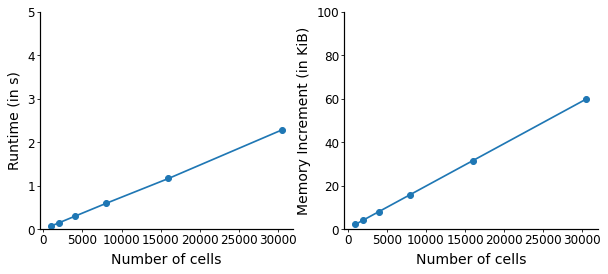

In [16]:
with mplscience.style_context():
  fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10, 4)
  )

  # ax1.plot(subset_sizes, np.array(mem_usages) / 1024, marker="o")
  # ax1.set_title("setup_anndata Memory Usage Profiling")
  # ax1.set_xlabel("Number of cells")
  # ax1.set_ylabel("Memory Usage (in GiB)")
  # ax1.set_ylim((0, 10))

  ax2.plot(subset_sizes, srun, marker="o")
  # ax2.set_title("scVI setup_anndata Runtime Profiling")
  ax2.set_xlabel("Number of cells")
  ax2.set_ylabel("Runtime (in s)")
  ax2.set_ylim((0, 5))

  ax3.plot(subset_sizes, np.array(smem) * 1024, marker="o")
  # ax3.set_title("scVI setup_anndata Memory Profiling")
  ax3.set_xlabel("Number of cells")
  ax3.set_ylabel("Memory Increment (in KiB)")
  ax3.set_ylim((0, 100))

  fig.savefig("scVI_setup_anndata_profiling.pdf",  bbox_inches="tight", dpi=300)